<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Heshani/predition2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RBC 1: healthy
RBC 2: healthy
RBC 3: healthy
RBC 4: healthy
RBC 5: healthy
RBC 6: healthy
RBC 7: healthy
RBC 8: healthy
RBC 9: healthy
RBC 10: healthy
RBC 11: healthy
RBC 12: healthy
RBC 13: healthy
RBC 14: healthy
RBC 15: healthy
RBC 16: healthy
RBC 17: healthy
RBC 18: healthy
RBC 19: healthy
RBC 20: healthy
RBC 21: healthy
RBC 22: healthy


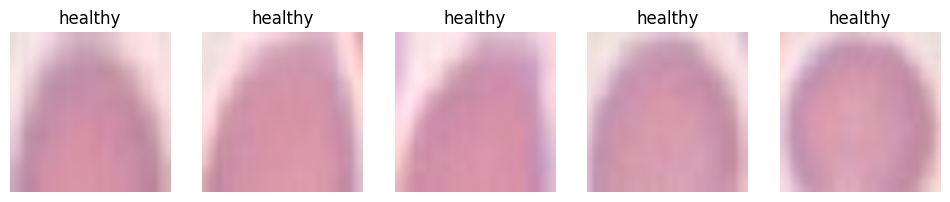

In [ ]:
# ========================
# Prediction Code for Trained RBC Model
# ========================

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt

# ========================
# Config
# ========================
IMG_SIZE = 128
MAX_RBC_PER_IMAGE = 25

# ========================
# Load Saved Model & Encoders
# ========================
model = load_model("/content/drive/MyDrive/new2/cnn_vit_rbc_test_trainsplit.keras")
le = pickle.load(open("/content/drive/MyDrive/new2/label_encoder (1).pkl", "rb"))
scaler = pickle.load(open("/content/drive/MyDrive/new2/scaler (1).pkl", "rb"))

# ========================
# Handcrafted Features (same as training)
# ========================
def target_cell_score(gray):
    h, w = gray.shape
    cx, cy = w//2, h//2
    Y, X = np.ogrid[:h, :w]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)
    r = np.max(d)
    c = gray[d < r*0.25]
    m = gray[(d >= r*0.25) & (d < r*0.5)]
    o = gray[(d >= r*0.5) & (d < r*0.75)]
    if len(c)==0 or len(m)==0 or len(o)==0:
        return 0
    return (np.mean(m)-np.mean(c)) + (np.mean(m)-np.mean(o))

def blue_ratio(rbc):
    b, g, r = cv2.split(rbc)
    return np.mean(b)/(np.mean(r)+1e-5)

def compute_rbc_features(rbc):
    gray = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    return [target_cell_score(gray), blue_ratio(rbc), abs(h-w)/max(h,w), h*w]

# ========================
# Extract RBCs from Image
# ========================
def extract_rbcs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cells, feats = [], []
    for c in contours[:MAX_RBC_PER_IMAGE]:
        if cv2.contourArea(c) < 100:
            continue
        x, y, w, h = cv2.boundingRect(c)
        rbc = image[y:y+h, x:x+w]
        cells.append(cv2.resize(rbc, (IMG_SIZE, IMG_SIZE)))
        feats.append(compute_rbc_features(rbc))
    return np.array(cells), np.array(feats)

# ========================
# Prediction Function
# ========================
def predict_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        return

    X_cells, f_cells = extract_rbcs(image)
    if len(X_cells) == 0:
        print("⚠️ No RBCs detected in the image.")
        return

    # Scale features
    f_cells_scaled = scaler.transform(f_cells)

    # Predict
    preds = model.predict([X_cells, f_cells_scaled])
    class_idx = np.argmax(preds, axis=1)
    class_labels = le.inverse_transform(class_idx)

    # Display results
    for i, label in enumerate(class_labels):
        print(f"RBC {i+1}: {label}")

    # Optionally, show first 5 RBCs with predicted label
    plt.figure(figsize=(12,3))
    for i in range(min(5, len(X_cells))):
        plt.subplot(1,5,i+1)
        plt.imshow(cv2.cvtColor(X_cells[i], cv2.COLOR_BGR2RGB))
        plt.title(class_labels[i])
        plt.axis('off')
    plt.show()

# ========================
# Example Usage
# ========================
image_path = "/content/drive/MyDrive/new2/images/healthy_web .jpg"  # <-- replace with your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RBC 1: likely_thalassemia
RBC 2: healthy
RBC 3: healthy
RBC 4: likely_thalassemia
RBC 5: healthy
RBC 6: healthy
RBC 7: healthy
RBC 8: healthy
RBC 9: likely_thalassemia
RBC 10: healthy
RBC 11: healthy
RBC 12: healthy
RBC 13: healthy
RBC 14: healthy
RBC 15: healthy
RBC 16: healthy


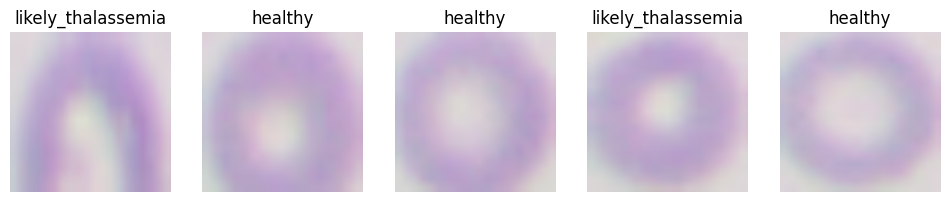

In [ ]:
image_path = "/content/drive/MyDrive/new2/images/heal_anemia.png"  # <-- replace with your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
RBC 1: likely_thalassemia
RBC 2: likely_thalassemia
RBC 3: healthy
RBC 4: healthy
RBC 5: likely_thalassemia
RBC 6: likely_thalassemia
RBC 7: healthy
RBC 8: likely_thalassemia
RBC 9: healthy
RBC 10: likely_thalassemia


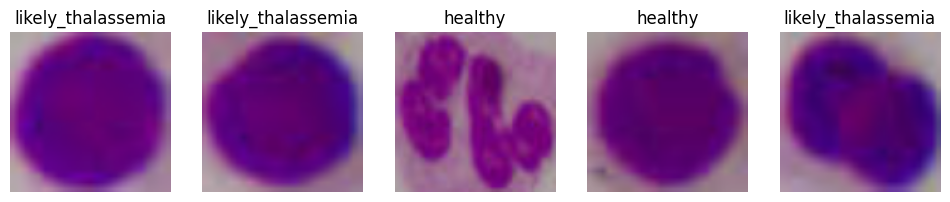

In [ ]:
image_path = "/content/drive/MyDrive/thalassemiatest/thalassemia_web.jpg"  # <-- replace with your image path
predict_image(image_path)
